In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [20]:
num_data = 2000
num_val = int(num_data * 0.1)
num_train = int(num_data * 0.8)
num_test = num_data - num_val - num_train
# 准备训练数据
x = (torch.rand(num_data) * 15 + 1).unsqueeze(1)
y = torch.cos(torch.pi * x / 2) + torch.log2(x)
noise = torch.randn(1) * 0.01
y += noise

# 划分测试集
x_train = x[:num_train]
y_train = y[:num_train]
x_test = x[-num_test:]
y_test = y[-num_test:]
x_val = x[num_train:num_train + num_val]
y_val = y[num_train:num_train + num_val]

In [21]:
# multiple layers perceptron to fit log + cos function
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units

        # 创建隐藏层
        self.hidden = nn.ModuleList()
        for _ in range(hidden_layers):
            self.hidden.append(nn.Linear(input_size, hidden_units))
            self.hidden.append(nn.Tanh())
            input_size = hidden_units

        # 输出层
        self.output = nn.Linear(hidden_units, output_size)
    
    def forward(self, x):
        for layer in self.hidden:
            x = layer(x)
        x = self.output(x)
        return x



In [22]:
# 创建 DataLoader
batch_size = 32
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# 初始化模型
model = [MLP(1, 1, 2, 64), MLP(1, 1, 3, 32), MLP(1, 1, 4, 32),MLP(1, 1, 4, 32), MLP(1, 1, 4, 32)]

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = []
for i in range(len(model)):
    optimizer.append(optim.Adam(model[i].parameters(), lr=0.001))
optimizer[-1] = optim.SGD(model[-1].parameters(), lr=0.01)
optimizer[-2] = optim.Adam(model[-2].parameters(), lr=0.01)

Model 0, Epoch [100/300], Avg Loss: 0.2666
Model 0, Epoch [200/300], Avg Loss: 0.1550
Model 0, Epoch [300/300], Avg Loss: 0.0010
Model 1, Epoch [100/300], Avg Loss: 0.2561
Model 1, Epoch [200/300], Avg Loss: 0.1380
Model 1, Epoch [300/300], Avg Loss: 0.0007
Model 2, Epoch [100/300], Avg Loss: 0.2471
Model 2, Epoch [200/300], Avg Loss: 0.0007
Model 2, Epoch [300/300], Avg Loss: 0.0012
Model 3, Epoch [100/300], Avg Loss: 0.0029
Model 3, Epoch [200/300], Avg Loss: 0.0133
Model 3, Epoch [300/300], Avg Loss: 0.0066
Model 4, Epoch [100/300], Avg Loss: 0.4271
Model 4, Epoch [200/300], Avg Loss: 0.3579
Model 4, Epoch [300/300], Avg Loss: 0.2829


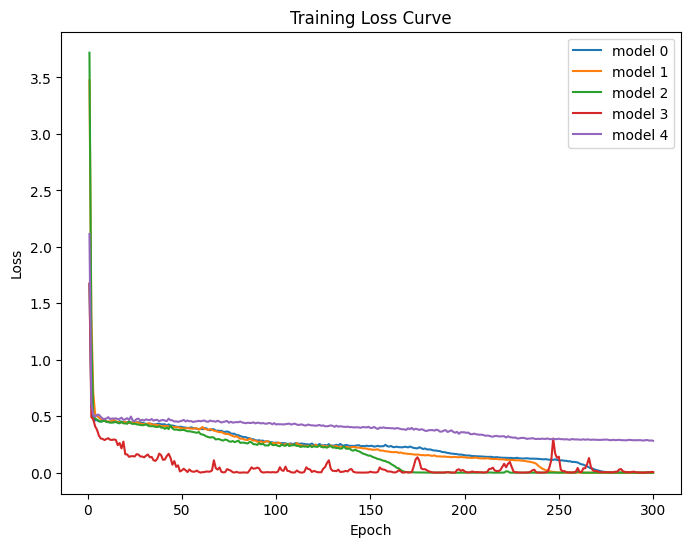

In [23]:
def train(model, criterion, optimizer, num_epochs=100, idx=0):
    # 记录损失值
    loss_vals = []

    # 训练模型
    for epoch in range(num_epochs):
        epoch_loss = []
        for i, (batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(batch_x)
            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())

        # 计算平均损失并记录
        avg_loss = sum(epoch_loss) / len(epoch_loss)
        loss_vals.append(avg_loss)

        if (epoch + 1) % 100 == 0:
            print(f"Model {idx}, Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")
    return loss_vals


# 绘制损失曲线
plt.figure(figsize=(8, 6))
num_epochs = 300
for i in range(len(model)):
    loss_vals = train(model[i], criterion, optimizer[i], num_epochs=num_epochs, idx=i)
    plt.plot(range(1, num_epochs+1), loss_vals, label=f"model {i}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

Model 0, Validation Loss: 0.0015
Model 1, Validation Loss: 0.0004
Model 2, Validation Loss: 0.0021
Model 3, Validation Loss: 0.0068
Model 4, Validation Loss: 0.3326


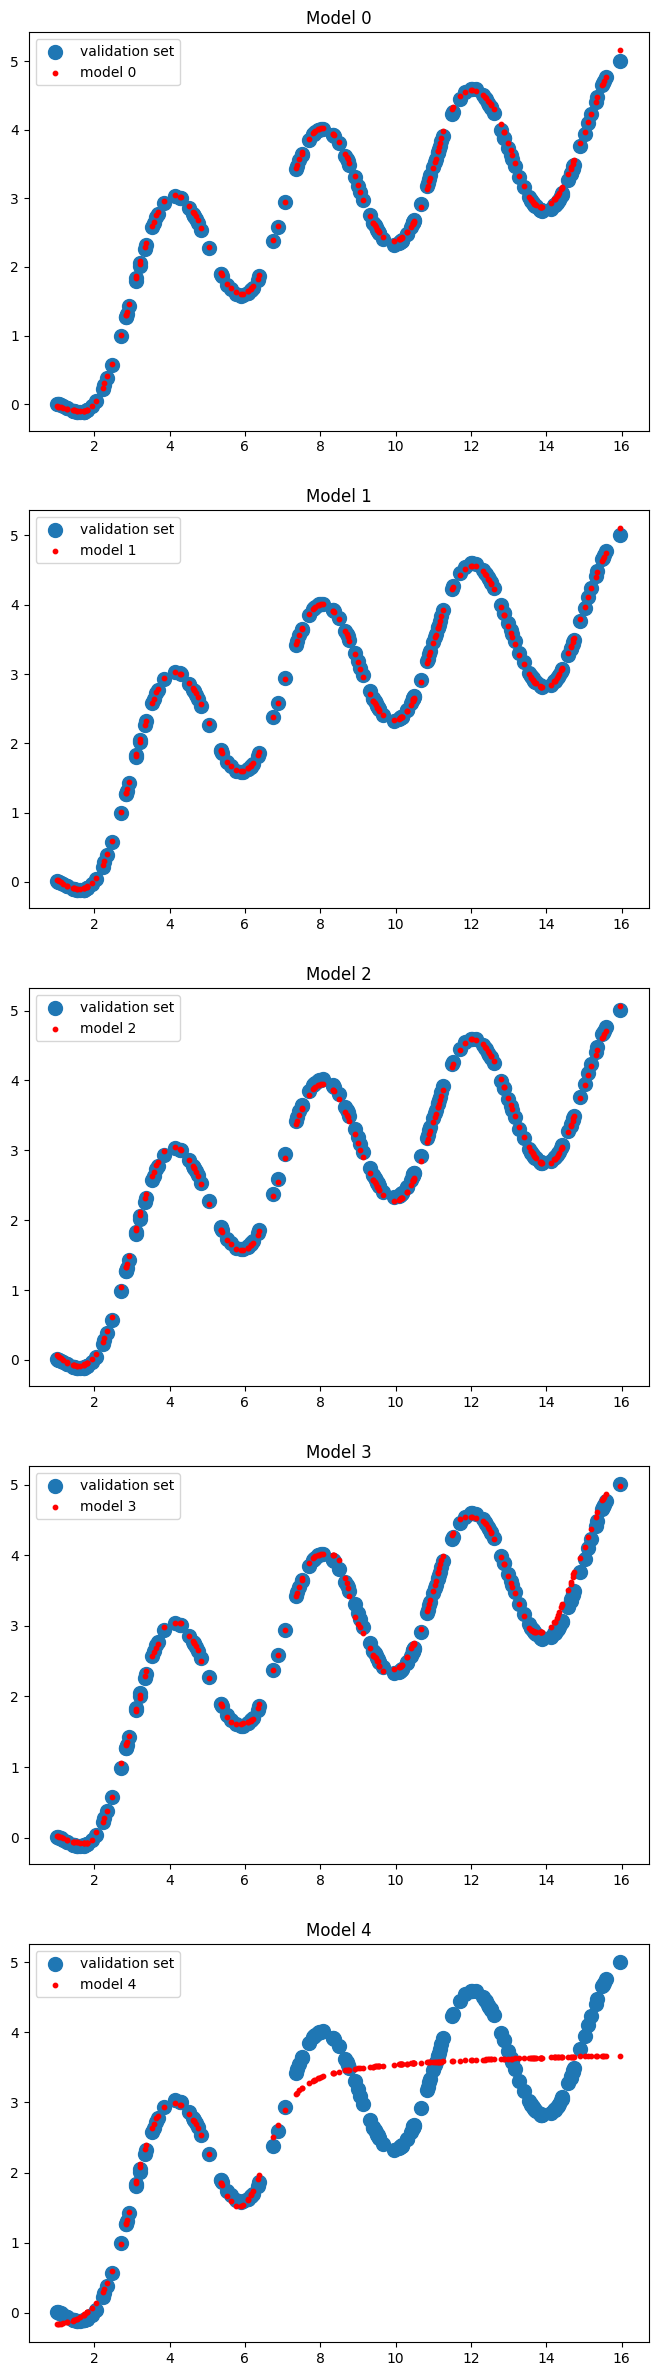

In [24]:
# 验证val_set的效果
def evaluate(model, x, y):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    return loss.item()

fig, axs = plt.subplots(len(model), figsize=(8, 6*len(model)))

#marker_list = ['o', 'x', 's', 'd', '^']

min_loss = 1
for i in range(len(model)):
    loss = evaluate(model[i], x_val, y_val)
    print(f"Model {i}, Validation Loss: {loss:.4f}")
    if loss < min_loss:
        min_loss = loss
        best_model = model[i]
    axs[i].scatter(x_val, y_val, s=100,label="validation set")
    axs[i].scatter(x_val, model[i](x_val).detach().numpy(), s=10, color='r', label=f'model {i}')
    axs[i].set_title(f"Model {i}")
    axs[i].legend()
plt.show()


In [25]:
# 挑选效果最好的模型，测试test_set的效果
loss = evaluate(best_model, x_test, y_test)
print(f"Best Model, Test Loss: {loss:.4f}")

Best Model, Test Loss: 0.0004


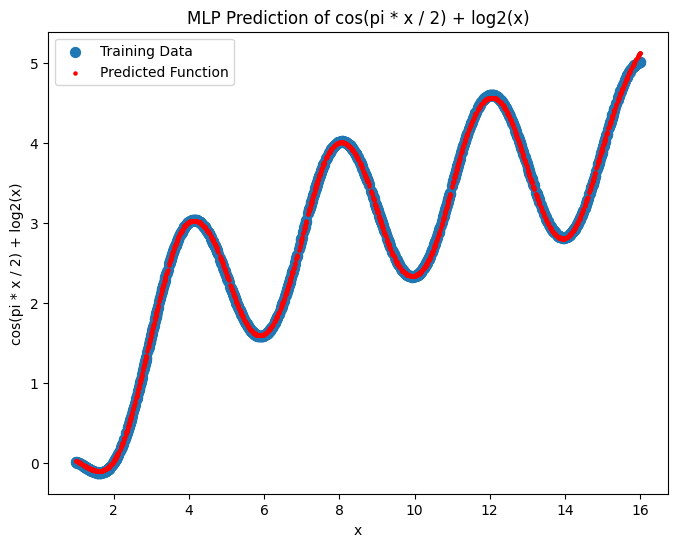

In [26]:
# 预测
y_pred= best_model(x)

# 可视化结果
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=50, label="Training Data")
plt.scatter(x, y_pred.detach().numpy(), color='r', s=5, label="Predicted Function")
plt.xlabel("x")
plt.ylabel("cos(pi * x / 2) + log2(x)")
plt.title("MLP Prediction of cos(pi * x / 2) + log2(x)")
plt.legend()
plt.show()